In [1]:
!nvidia-smi
%load_ext autoreload
%autoreload 2

Wed Oct 30 13:42:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               On  | 00000000:1A:00.0 Off |                  N/A |
| 41%   29C    P8              15W / 280W |      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [38]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import time
import numpy as np

# Function to calculate entropy
def entropy(probs):
    # Calculate bit entropy of probs
    entropy = -(probs * torch.log2(probs + 1e-12)).sum()
    return entropy

def benchmark_time(models, tokenizer, prompt, trials=10):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    
    # Initialize dictionary to store times
    times = {model_name: [] for model_name in models}
    
    # Benchmark the forward pass for each model
    for model_name, model in models.items():
        for _ in range(trials):
            start = time.time()
            with torch.no_grad():
                _ = model(input_ids)
            end = time.time()
            times[model_name].append(end - start)
    return times
    
def plot_top_k_probs(models, tokenizer, prompt, k=10):
    # Tokenize and encode the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    # Collect top-k token indices across all models
    all_top_k_tokens = set()
    model_probs = {}

    # Compute top k tokens for each model
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits[:, -1, :]  # Focus on the last token
        
        # Calculate the probabilities and get top-k tokens and indices
        probs = torch.nn.functional.softmax(logits, dim=-1).squeeze()
        top_k_probs, top_k_indices = torch.topk(probs, k)
        
        # Store these for plotting and expand the union of top-k tokens
        model_probs[name] = (top_k_probs, top_k_indices)
        all_top_k_tokens.update(top_k_indices.cpu().numpy())

    # Calculate total probability for sorting
    all_top_k_tokens = list(all_top_k_tokens)
    total_probs = {token: 0 for token in all_top_k_tokens}

    for name, (top_k_probs, top_k_indices) in model_probs.items():
        for idx, prob in zip(top_k_indices.cpu().numpy(), top_k_probs.cpu().numpy()):
            total_probs[idx] += prob  # Add up probabilities across models

    # Sort tokens by their cumulative probability across all models
    sorted_tokens = sorted(total_probs, key=total_probs.get, reverse=True)

    # Prepare plot data by following the sorted order
    plot_data = {name: [] for name in models}
    sorted_tokens.append("Other Tokens")  # Add "Other Tokens" as the last bar

    for name, (top_k_probs, top_k_indices) in model_probs.items():
        probs_dict = dict(zip(top_k_indices.cpu().numpy(), top_k_probs.cpu().numpy()))
        remaining_prob = 1.0 - sum(probs_dict.values())  # Remaining probability for "Other Tokens"

        # Append probabilities for each token in sorted order
        for token in sorted_tokens[:-1]:  # All tokens except "Other Tokens"
            plot_data[name].append(probs_dict.get(token, 0.0))  # Append 0 if token not in top-k
        
        # Append the "Other Tokens" probability
        plot_data[name].append(remaining_prob)

    # Decode the sorted tokens for labeling
    sorted_tokens_labels = [tokenizer.decode([idx]) if idx != "Other Tokens" else idx for idx in sorted_tokens]

    # Plotting
    x = np.arange(len(sorted_tokens_labels))  # Label locations
    width = 0.2  # Width of each bar
    fig, ax = plt.subplots(figsize=(2 + k*0.5, 5))

    # Create a bar plot for each model
    for i, (name, probs) in enumerate(plot_data.items()):
        ax.bar(x + i * width, probs, width, label=name)

    # Add labels, title, and legend
    ax.set_xlabel("Token")
    ax.set_ylabel("Probability")
    ax.set_title(f"Top {k} Token Probabilities and Remaining Probability for Prompt: '{prompt}'")
    ax.set_xticks(x + width * (len(models) - 1) / 2)  # Center x-ticks
    ax.set_xticklabels(sorted_tokens_labels, rotation=45, ha="right")
    ax.legend(title="Models")

    plt.show()

In [3]:
model_names = ['meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Llama-3.1-8B']#, 'meta-llama/Llama-3.1-70B']
models = {model_name.split('/')[-1]: AutoModelForCausalLM.from_pretrained(model_name) for model_name in model_names}
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.2-1B')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
# Define the prompt and tokenize it
prompt = "Once upon a time,"  # Replace with your prompt
length = 10  # Number of tokens to generate
baseline = 'Llama-3.1-8B'
explorer = 'Llama-3.2-1B'
temperature = 1

In [21]:
times = benchmark_time(models, tokenizer, prompt)
for model_name, model_times in times.items():
    print(f"{model_name}: {torch.tensor(model_times).mean():.1f} +/- {2*torch.tensor(model_times).std():.1f} seconds per token.")

Llama-3.2-1B: 0.2 +/- 0.0 seconds per token.
Llama-3.2-3B: 0.6 +/- 0.0 seconds per token.
Llama-3.1-8B: 1.3 +/- 0.0 seconds per token.


[' there', ' I', ' in', ' a', ' the', ' when', ' we', ' it', ' before', ' you', ' my', ' back', ' not', ' people', ' an', ' long', ' if', ' on', ' all', ' ', ' at', ' many', ' this', ' two', ' as', ' our', ' one', ' some', ' during', ' someone', ' way', ' most', ' every', 'Other Tokens']


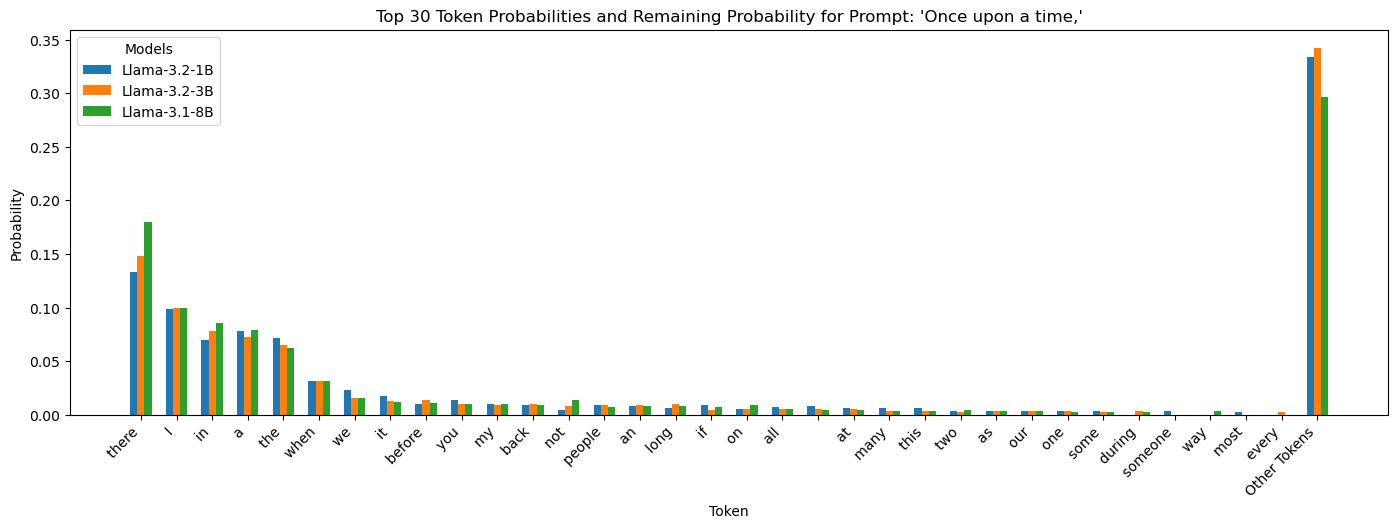

In [37]:
plot_top_k_probs(models, tokenizer, prompt, k=30)

In [5]:
# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]

# Generate baseline text
baseline_model = models[baseline]
baseline_model.eval()
with torch.no_grad():
    next_input_ids = input_ids
    for _ in range(length):
        outputs = baseline_model(next_input_ids)
        logits = outputs.logits[:, -1, :]
        probs = F.softmax(logits/temperature, dim=-1) 
        next_token_id = torch.argmax(probs, dim=-1, keepdim=True)
        next_input_ids = torch.cat([next_input_ids, next_token_id], dim=-1)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [6]:
# Decode the generated text
baseline_text = tokenizer.decode(next_input_ids[0], skip_special_tokens=False, clean_up_tokenization_spaces=False)
print("Baseline Text:", baseline_text)

Baseline Text: <|begin_of_text|>Once upon a time, there was a little girl who loved to read.


In [7]:
# Initialize dictionary to store entropy values
model_entropies = {key: [] for key in llama_models}

# Generate text and calculate entropy
for name, model in llama_models.items():
    model.eval()
    with torch.no_grad():
        for i in range(length):
            outputs = model(next_input_ids[0, :len(input_ids[0]) + i].unsqueeze(0))
            logits = outputs.logits[:, -1, :]
            probs = F.softmax(logits/temperature, dim=-1) 
            model_entropies[name].append(entropy(probs))

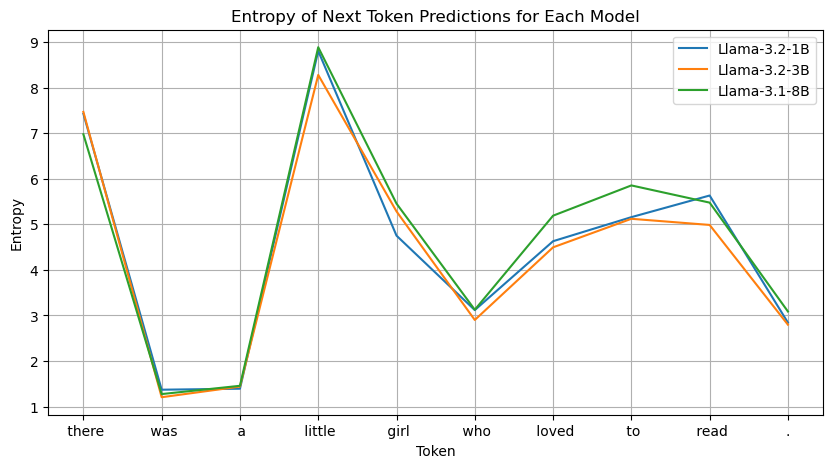

In [8]:
# Plotting the entropy
plt.figure(figsize=(10, 5))
for name, entropies in model_entropies.items():
    plt.plot(range(length), entropies, label=f'{name}')
token_list = [tokenizer.decode(token_id) for token_id in next_input_ids[0, len(input_ids[0]):]]
plt.xticks(range(length), token_list)
plt.xlabel('Token')
plt.ylabel('Entropy')
plt.title('Entropy of Next Token Predictions for Each Model')
plt.legend()
plt.grid(True)
plt.show()

# Old stuff

In [ ]:
# Initialize variables for tracking top-k logits, tokens, selected tokens, and generated text
entropies = []
top_k_logits = []
top_k_tokens = []
selected_tokens = []
generated_text = [prompt]  # Start with the prompt

# Set the number of tokens to generate and the number of top-k tokens to track
max_length = len(input_ids[0]) + 20  # Generate up to 20 additional tokens
top_k = 20  # Number of top-k tokens to display

# Generate tokens step-by-step and collect logits for top-k tokens
with torch.no_grad():
    for i in range(max_length - len(input_ids[0])):
        # Get model outputs
        outputs = model(input_ids=input_ids)
        logits = outputs.logits

        # Take the logits of the last generated token
        last_token_logits = logits[:, -1, :]
        
        # Calculate probability distribution and entropy for the last token
        probs = F.softmax(last_token_logits, dim=-1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-9))  # Adding a small constant to avoid log(0)
        entropies.append(entropy.item())


        # Get the top-k logits and tokens
        top_k_values, top_k_indices = torch.topk(last_token_logits, top_k)
        top_k_tokens.append([tokenizer.decode(idx) for idx in top_k_indices[0]])
        top_k_logits.append(top_k_values[0].cpu().numpy())  # Store top-k logits

        # Sample next token and store the selected one
        next_token = torch.multinomial(F.softmax(last_token_logits, dim=-1), num_samples=1)
        selected_token_text = tokenizer.decode(next_token[0])
        selected_tokens.append(selected_token_text)

        # Append the selected token to input_ids and generated_text
        input_ids = torch.cat((input_ids, next_token), dim=1)  # Update input_ids with the new token
        generated_text.append(selected_token_text)  # Add token to generated_text list

        # Stop generation if the model outputs an end-of-sequence token
        if next_token.item() == tokenizer.eos_token_id:
            break

# Print the generated sentence
print("Generated Sentence:", " ".join(generated_text))

In [ ]:
# Plot the entropy evolution
plt.figure(figsize=(18, 8))
plt.plot(entropies, marker='o', color='b', label="Entropy")
plt.xlabel("Token Position")
plt.ylabel("Entropy")
plt.title(prompt)

# Prepare the x-tick labels with vertically aligned lists
xtick_labels = []
for i, (top_k, selected) in enumerate(zip(top_k_tokens, selected_tokens)):
    # Create a vertical list with top-k tokens, marking the selected token in bold
    label_text = ""
    for tok in top_k:
        if tok == selected:
            label_text += f"$\\bf{{{tok}}}$\n"  # Bold the selected token
        else:
            label_text += f"{tok}\n"
    if selected not in top_k:
        label_text += f"$\\bf{{{selected}}}$"  # Add selected token at the end if not in top-k

    xtick_labels.append(label_text.strip())

# Set custom x-tick labels and align them
plt.xticks(ticks=range(len(entropies)), labels=xtick_labels, ha='center', fontsize=8)

# Display plot
plt.legend()
plt.show()

In [ ]:
# Plot the boxplot of logits for the top-k tokens at each step
plt.figure(figsize=(18, 8))
plt.boxplot(top_k_logits, positions=range(len(top_k_logits)), widths=0.6, patch_artist=True)
plt.xlabel("Token Position")
plt.ylabel("Logits of Top-k Tokens")
plt.title("Boxplot of Logits for Top-k Tokens at Each Generation Step")

# Set custom x-tick labels to show token positions with top-k tokens
xtick_labels = []
for i, (top_k, selected) in enumerate(zip(top_k_tokens, selected_tokens)):
    # Create a vertical list with top-k tokens, marking the selected token in bold
    label_text = ""
    for tok in top_k:
        if tok == selected:
            label_text += f"$\\bf{{{tok}}}$\n"  # Bold the selected token
        else:
            label_text += f"{tok}\n"
    if selected not in top_k:
        label_text += f"$\\bf{{{selected}}}$"  # Add selected token at the end if not in top-k

    xtick_labels.append(label_text.strip())

# Set custom x-tick labels and align them
plt.xticks(ticks=range(len(top_k_logits)), labels=xtick_labels, ha='center', fontsize=8)

# Display the plot
plt.show()

In [ ]:
# Set up a list to store DKL values for each token across layers
dkl_across_layers = [[] for _ in range(input_ids.size(1))]  # One list per token in the prompt

# Forward pass through the model to extract all hidden states
with torch.no_grad():
    outputs = model(input_ids=input_ids, output_hidden_states=True)
    all_layer_logits = [layer_output @ model.lm_head.weight.T for layer_output in outputs.hidden_states]

# Calculate probability distribution of the last layer for each token
final_layer_logits = all_layer_logits[-1]
final_probs = F.softmax(final_layer_logits, dim=-1)

# Compute DKL for each layer with respect to the final layer
for layer_index, layer_logits in enumerate(all_layer_logits):  # Exclude final layer from comparison
    layer_probs = F.softmax(layer_logits, dim=-1)
    dkl = F.kl_div(layer_probs.log(), final_probs, reduction="none").sum(dim=-1)  # Token-wise DKL
    for token_idx in range(dkl.size(1)):
        dkl_across_layers[token_idx].append(dkl[0, token_idx].item())  # Store DKL per layer for each token

In [ ]:
# Plotting DKL for each token across layers
num_layers = len(dkl_across_layers[0])  # Number of layers
num_tokens = len(dkl_across_layers)     # Number of tokens

fig, axes = plt.subplots(1, num_tokens, figsize=(4 * num_tokens, 6), sharey=True)
fig.suptitle("DKL Across Layers for Each Token", fontsize=16)

# Create a subplot for each token
for token_idx, ax in enumerate(axes):
    ax.plot(range(num_layers), dkl_across_layers[token_idx], marker="o", color="b")
    ax.set_title(f"Token: {tokenizer.decode(input_ids[0, token_idx])}")
    ax.set_xlabel("Layer")
    ax.set_ylabel("DKL to Final Layer" if token_idx == 0 else "")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Define the prompt and tokenize it
prompt = "Once upon a time in a land far, far away"  # Replace with your prompt
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]

# Set the number of generated tokens and top-k
num_generated_tokens = 10  # Number of tokens to generate
top_k = 1  # Number of top-k tokens to consider

# Collect overlap percentages per token per layer
overlap_percentages_per_token = []
# Initialize the list to store generated tokens
generated_tokens = []

# Get the total number of layers (excluding the embedding layer)
num_layers = len(model.model.layers)

# Generate tokens step by step
generated_input_ids = input_ids.clone()

for token_idx in range(num_generated_tokens):
    with torch.no_grad():
        # Get the model outputs with hidden states
        outputs = model(input_ids=generated_input_ids, output_hidden_states=True)
        # Hidden states is a tuple with outputs from each layer (including embeddings)
        hidden_states = outputs.hidden_states  # Tuple: (embeddings, layer 1 output, ..., layer N output)
    
        # Get the final layer's hidden state for the last token
        hidden_state_final = hidden_states[-1][:, -1, :]  # Shape: (batch_size, hidden_size)
    
        # Pass the final hidden state through the lm_head to get logits
        logits_final = model.lm_head(hidden_state_final)  # Shape: (batch_size, vocab_size)
    
        # Get the top-k tokens from the final layer
        probs_final = F.softmax(logits_final, dim=-1)
        _, topk_indices_final = torch.topk(probs_final, top_k, dim=-1)
        set_final = set(topk_indices_final[0].cpu().numpy())
    
        # Initialize list to store overlap percentages for this token
        overlap_percentages = []
    
        # Iterate over layers (excluding the embedding layer at index 0)
        for layer_idx in range(1, len(hidden_states)):
            # Get the hidden state at current layer for the last token
            hidden_state_l = hidden_states[layer_idx][:, -1, :]  # Shape: (batch_size, hidden_size)
            # Get logits by passing through the lm_head
            logits_l = model.lm_head(hidden_state_l)  # Shape: (batch_size, vocab_size)
            # Get probabilities
            probs_l = F.softmax(logits_l, dim=-1)
            # Get top-k tokens
            _, topk_indices_l = torch.topk(probs_l, top_k, dim=-1)
            set_l = set(topk_indices_l[0].cpu().numpy())
            # Calculate overlap percentage with the final layer's top-k
            overlap_count = len(set_l.intersection(set_final))
            overlap_percentage = (overlap_count / top_k) * 100
            overlap_percentages.append(overlap_percentage)
    
        # Store overlap percentages for this token
        overlap_percentages_per_token.append(overlap_percentages)
    
        # Generate the next token using the final layer's probabilities (greedy decoding)
        next_token_id = logits_final.argmax(dim=-1, keepdim=True)  # Shape: (batch_size, 1)
        generated_input_ids = torch.cat([generated_input_ids, next_token_id], dim=-1)
    
        # Decode the generated token and append to the list
        token_str = tokenizer.decode(next_token_id[0], skip_special_tokens=True).strip()
        generated_tokens.append(token_str)

# Now, plot the overlap percentages per token
num_subplots = num_generated_tokens
cols = 2  # Adjust the number of columns in the subplot grid
rows = math.ceil(num_subplots / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows))

for idx, (token_idx, overlap_percentages) in enumerate(zip(range(num_generated_tokens), overlap_percentages_per_token)):
    ax = axs.flat[idx]
    layers = list(range(1, len(hidden_states)))  # Layer indices starting from 1
    ax.plot(layers, overlap_percentages, marker="o")
    # Use the generated token in the title
    token_str = generated_tokens[idx]
    ax.set_title(f"Token {token_idx + 1}: '{token_str}'")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Overlap Percentage (%)")
    ax.set_xticks(layers)
    ax.grid(True)

# Hide any unused subplots
for idx in range(num_subplots, len(axs.flat)):
    fig.delaxes(axs.flat[idx])

plt.tight_layout()
plt.show()